# Iteration 2 - TableNet Model 3.0

> **Dataset**: Client Dataset <br/>
> **Model**: TableNet Model <br/>
> **Creator**: Ryo

In [ ]:
import os
import xml.etree.ElementTree as ET

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import albumentations as A
from google.colab import files,drive

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, applications
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
drive.mount('/content/drive')

In [ ]:
IMAGE_FOLDER = '/content/drive/MyDrive/tablenet_data/images/4. Cropped'
MASK_FOLDER = '/content/drive/MyDrive/tablenet_data/masking/4. Cropped Masks'

ANNOTATION_TYPES = ["cell", "information"]

In [ ]:
def create_complete_file_table(image_folder, mask_folder):
    image_paths = [
        os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".JPG")
    ]

    mask_paths = {annotation_type: [] for annotation_type in ANNOTATION_TYPES}

    def find_mask_path(base_name, subfolder):
        for root, _, files in os.walk(subfolder):
            for file in files:
                if file == f"{base_name}.png":
                    return os.path.join(root, file)
        return None

    for image_path in image_paths:
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        for annotation_type in ANNOTATION_TYPES:
            mask_subfolder = os.path.join(mask_folder, annotation_type)
            mask_file = find_mask_path(base_name, mask_subfolder)
            mask_paths[annotation_type].append(mask_file)

    data = {"image": image_paths}
    for annotation_type in ANNOTATION_TYPES:
        data[f"{annotation_type}_mask"] = mask_paths[annotation_type]

    return pd.DataFrame(data)

In [ ]:
file_table = create_complete_file_table(IMAGE_FOLDER, MASK_FOLDER)

In [ ]:
def split_dataset(df, test_size=0.2, val_size=0.1, random_state=42):
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, random_state=random_state)
    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = split_dataset(
    file_table,
    test_size=0.05,
    val_size=0.2,
    random_state=42
)

total_size = len(train_df) + len(val_df) + len(test_df)

print(f"Training set size: {len(train_df)} ({len(train_df) / total_size:.2%})")
print(f"Validation set size: {len(val_df)} ({len(val_df) / total_size:.2%})")
print(f"Test set size: {len(test_df)} ({len(test_df) / total_size:.2%})")

In [ ]:
def extract_paths(df):
    image_paths = df['image'].values
    mask_paths = {col: df[col].values for col in df.columns if '_mask' in col}
    return image_paths, mask_paths

In [ ]:
train_image_paths, train_mask_paths = extract_paths(train_df)
val_image_paths, val_mask_paths = extract_paths(val_df)
test_image_paths, test_mask_paths = extract_paths(test_df)

In [ ]:
def replicate_data(image_paths, mask_paths, replicate_count):
    image_paths = list(np.tile(image_paths, replicate_count))
    mask_paths = {key: list(np.tile(values, replicate_count)) for key, values in mask_paths.items()}
    return image_paths, mask_paths

In [ ]:
replicate_count = 4
train_image_paths, train_mask_paths = replicate_data(train_image_paths, train_mask_paths, replicate_count)

In [ ]:
print("Number of images after replication:", len(train_image_paths))
print("Number of masks after replication:", {k: len(v) for k, v in train_mask_paths.items()})

In [ ]:
def check_image_mask_dimensions(image_paths, mask_paths):
    for idx, img_path in enumerate(image_paths):
        image = cv2.imread(img_path)
        image_shape = image.shape[:2]  # Height, Width

        for key, mask_list in mask_paths.items():
            mask = cv2.imread(mask_list[idx], cv2.IMREAD_GRAYSCALE)
            mask_shape = mask.shape

            if image_shape != mask_shape:
                print(f"Mismatch found at index {idx}:")
                print(f"Image: {img_path} - Shape: {image_shape}")
                print(f"Mask: {mask_list[idx]} (Type: {key}) - Shape: {mask_shape}")
                return False
    print("All images and masks have matching dimensions.")
    return True

In [ ]:
is_consistent = check_image_mask_dimensions(train_image_paths, train_mask_paths)

if not is_consistent:
    print("Found mismatched dimensions. Please fix the dataset.")

In [ ]:
def augment_data(image_paths, mask_paths, augment=False):
    augmentation_pipeline = A.Compose([
        A.Rotate(limit=5, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=0, p=0.5,
                           border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.OneOf([
            A.OpticalDistortion(distort_limit=0.05, p=0.3),
            A.GridDistortion(num_steps=5, distort_limit=0.03, p=0.3),
        ], p=0.3),
        A.PadIfNeeded(min_height=1824, min_width=1760, border_mode=cv2.BORDER_CONSTANT, value=255),
        A.RandomCrop(height=1824, width=1760, p=0.5),
        A.Resize(height=1824, width=1760, always_apply=True),
    ], additional_targets={key: "mask" for key in mask_paths.keys()}, is_check_shapes=False)

    augmented_images = []
    augmented_masks = {key: [] for key in mask_paths.keys()}

    for idx, img_path in enumerate(image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masks = {key: cv2.imread(mask_paths[key][idx], cv2.IMREAD_GRAYSCALE) for key in mask_paths.keys()}

        for key in masks.keys():
            assert image.shape[:2] == masks[key].shape, f"Mismatch in dimensions for {img_path} and {key}"

        if augment:
            transformed = augmentation_pipeline(
                image=image,
                **{key: mask for key, mask in masks.items()}
            )
            image = transformed['image']
            for key in mask_paths.keys():
                augmented_masks[key].append(transformed[key])
        else:
            for key in mask_paths.keys():
                augmented_masks[key].append(masks[key])

        augmented_images.append(image)

    return augmented_images, augmented_masks

In [ ]:
train_images, train_masks = augment_data(
    train_image_paths,
    train_mask_paths,
    augment=True
)

val_images, val_masks = augment_data(
    val_image_paths,
    val_mask_paths,
    augment=False
)

test_images, test_masks = augment_data(
    test_image_paths,
    test_mask_paths,
    augment=False
)

In [ ]:
def validate_tensor_data(images, masks):
    for idx, image in enumerate(images):
        if not isinstance(image, (np.ndarray, list)):
            raise ValueError(f"Invalid image data at index {idx}: {type(image)}")
        if image is None:
            raise ValueError(f"NoneType found in images at index {idx}")

    for key, mask_list in masks.items():
        for idx, mask in enumerate(mask_list):
            if not isinstance(mask, (np.ndarray, list)):
                raise ValueError(f"Invalid mask data at index {idx} for key {key}: {type(mask)}")
            if mask is None:
                raise ValueError(f"NoneType found in masks at index {idx} for key {key}")
    print("All data validated successfully.")

In [ ]:
validate_tensor_data(train_images, train_masks)
validate_tensor_data(val_images, val_masks)
validate_tensor_data(test_images, test_masks)

In [ ]:
def load_dataset(images, masks, batch_size, shuffle=True, seed=None):
    def parse(image, *mask_values):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)

        masks_dict = {
            f"{ANNOTATION_TYPES[i]}_output": tf.image.convert_image_dtype(mask, dtype=tf.float32)[..., tf.newaxis]
            for i, mask in enumerate(mask_values)
        }
        return image, masks_dict

    dataset_inputs = [images] + [masks[key] for key in masks.keys()]
    dataset = tf.data.Dataset.from_tensor_slices(tuple(dataset_inputs))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(len(images), 1000), seed=seed)

    dataset = dataset.map(
        lambda image, *masks: parse(image, *masks),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset, len(images)

In [ ]:
BATCH_SIZE_TRAIN = 2
BATCH_SIZE_VAL = 3
BATCH_SIZE_TEST = 3

In [ ]:
train_dataset, train_size = load_dataset(train_images, train_masks, BATCH_SIZE_TRAIN, shuffle=True)
val_dataset, val_size = load_dataset(val_images, val_masks, BATCH_SIZE_VAL, shuffle=False)
test_dataset, test_size = load_dataset(test_images, test_masks, BATCH_SIZE_TEST, shuffle=False)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")

In [ ]:
train_dataset

In [ ]:
def visualize_batch(batch, num_samples=5):
    images, masks = batch

    images = images.numpy() if isinstance(images, tf.Tensor) else images
    masks = {key: mask.numpy() if isinstance(mask, tf.Tensor) else mask for key, mask in masks.items()}

    batch_size = images.shape[0]
    num_samples = min(num_samples, batch_size)

    for i in range(num_samples):
        print(f"Sample {i + 1} Sizes:")
        print(f"  Image size: {images[i].shape}, Pixel range: {images[i].min()} to {images[i].max()}")
        for mask_name, mask_array in masks.items():
            print(f"  {mask_name.replace('_', ' ').capitalize()} size: {mask_array[i].shape}")

        plt.figure(figsize=(20, 5))

        plt.subplot(1, len(masks) + 1, 1)
        if images[i].max() <= 1.0:
            plt.imshow((images[i] * 255).astype('uint8'))
        else:
            plt.imshow(images[i].astype('uint8'))
        plt.title(f"Sample {i + 1}: Image")
        plt.axis('off')

        for j, (mask_name, mask_array) in enumerate(masks.items()):
            mask_to_plot = mask_array[i, :, :, 0] if mask_array[i].ndim == 4 else mask_array[i]
            plt.subplot(1, len(masks) + 1, j + 2)
            plt.imshow(mask_to_plot, cmap='gray')
            plt.title(f"Sample {i + 1}: {mask_name.replace('_', ' ').capitalize()}")
            plt.axis('off')

        plt.show()

In [ ]:
for batch in train_dataset.take(1):
    visualize_batch(batch, num_samples=1)

In [ ]:
def decoder_block(x, skip_features, filters, dilation_rate=2):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip_features])

    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, (3, 3), dilation_rate=dilation_rate, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, (3, 3), dilation_rate=dilation_rate, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    res = layers.Conv2D(filters, (1, 1), padding="same")(x)
    x = layers.Add()([x, res])

    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    return x

In [ ]:
def TableNet(input_shape=(1824, 1760, 3), annotation_types=None, trainable_blocks=2):
    inputs = layers.Input(shape=input_shape)

    # ResNet50 as encoder
    base_model = applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
    )

    # Freeze initial layers (depending on trainable_blocks)
    total_blocks = 5
    for layer in base_model.layers:
        if layer.name.startswith("conv") or layer.name.startswith("block"):
            block_number = int(layer.name.split("_")[0][-1])  # Extract block number
            layer.trainable = block_number >= (total_blocks - trainable_blocks)

    # Extract features
    skip1 = base_model.get_layer("conv1_conv").output  # (912, 880)
    skip2 = base_model.get_layer("conv2_block3_out").output  # (456, 440)
    skip3 = base_model.get_layer("conv3_block4_out").output  # (228, 220)
    skip4 = base_model.get_layer("conv4_block6_out").output  # (114, 110)
    bottleneck = base_model.get_layer("conv5_block3_out").output  # (57, 55)

    def decoder_block(x, skip_features, filters, dilation_rate=1):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
        x = layers.Concatenate()([x, skip_features])
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", dilation_rate=dilation_rate)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        return x

    # Decoder architecture for cell mask
    x_general = decoder_block(bottleneck, skip4, 256, dilation_rate=2)
    x_general = decoder_block(x_general, skip3, 128, dilation_rate=2)
    x_general = decoder_block(x_general, skip2, 64, dilation_rate=1)
    x_general = decoder_block(x_general, skip1, 32, dilation_rate=1)
    x_general = layers.Conv2DTranspose(32, (2, 2), strides=2, padding="same")(x_general)

    # Decoder architecture for information mask
    x_info = decoder_block(bottleneck, skip4, 256, dilation_rate=1)
    x_info = decoder_block(x_info, skip3, 128, dilation_rate=1)
    x_info = decoder_block(x_info, skip2, 64, dilation_rate=1)
    x_info = decoder_block(x_info, skip1, 32, dilation_rate=1)
    x_info = layers.Conv2DTranspose(32, (2, 2), strides=2, padding="same")(x_info)

    # Outputs
    cell_output = layers.Conv2D(1, (1, 1), activation="sigmoid", name="cell_output")(x_general)
    information_output = layers.Conv2D(1, (1, 1), activation="sigmoid", name="information_output")(x_info)

    model = models.Model(inputs=inputs, outputs=[cell_output, information_output])
    return model

In [ ]:
TARGET_SIZE = (1824, 1760)  # Height x Width
input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

model = TableNet(input_shape=input_shape, annotation_types=ANNOTATION_TYPES)

In [ ]:
model.output

In [ ]:
def binary_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

In [ ]:
def bce_dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.expand_dims(y_true, axis=-1) if len(y_true.shape) < len(y_pred.shape) else y_true
    y_pred = tf.squeeze(y_pred, axis=-1) if len(y_pred.shape) > len(y_true.shape) else y_pred

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    dice_loss = 1 - dice

    return bce + dice_loss

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'cell_output': bce_dice_loss,
        'information_output': bce_dice_loss
    },
    metrics={
        'cell_output': ['accuracy', binary_iou],
        'information_output': ['accuracy', binary_iou],
    },
    loss_weights={
        'cell_output': 0.2,
        'information_output': 0.8
    }
)


In [ ]:
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif 10 <= epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
class EarlyStoppingNotifier(tf.keras.callbacks.EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"\n[INFO] Early stopping triggered at epoch {self.stopped_epoch + 1}!")

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    lr_scheduler,
]

In [36]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=35,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35
90/90 ━━━━━━━━━━━━━━━━━━━━ 154s 505ms/step - cell_output_accuracy: 0.6847 - cell_output_binary_iou: 0.4426 - cell_output_loss: 0.2171 - information_output_accuracy: 0.6575 - information_output_binary_iou: 0.0419 - information_output_loss: 1.3248 - loss: 1.5419 - val_cell_output_accuracy: 0.6854 - val_cell_output_binary_iou: 0.1696 - val_cell_output_loss: 0.2522 - val_information_output_accuracy: 0.0181 - val_information_output_binary_iou: 0.0097 - val_information_output_loss: 1.7670 - val_loss: 2.0192 - learning_rate: 1.0000e-04
Epoch 2/35
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - cell_output_accuracy: 0.8558 - cell_output_binary_iou: 0.6959 - cell_output_loss: 0.1246 - information_output_accuracy: 0.9797 - information_output_binary_iou: 0.3694 - information_output_loss: 1.2187 - loss: 1.3433 - val_cell_output_accuracy: 0.6906 - val_cell_output_binary_iou: 0.2027 - val_cell_output_loss: 0.2267 - val_information_output_accuracy: 0.0213 - val_information_output_binary_iou: 0

In [37]:
def plot_history(history, metric_name, output_name):
    train_metric = history.history[f"{output_name}_{metric_name}"]
    val_metric = history.history[f"val_{output_name}_{metric_name}"]

    epochs = range(1, len(train_metric) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_metric, label=f"Train {output_name} {metric_name}")
    plt.plot(epochs, val_metric, label=f"Validation {output_name} {metric_name}")
    plt.title(f"{metric_name.capitalize()} for {output_name}")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.xticks(np.arange(1, len(epochs) + 1, 1))
    plt.legend()
    plt.grid()
    plt.show()

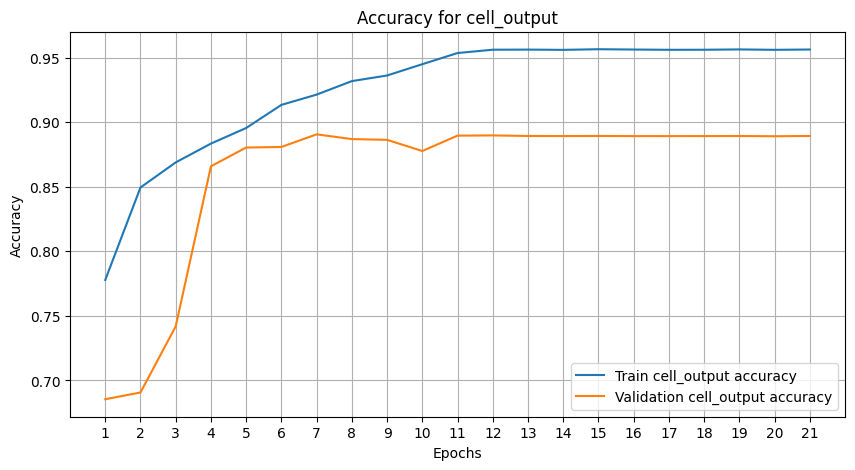

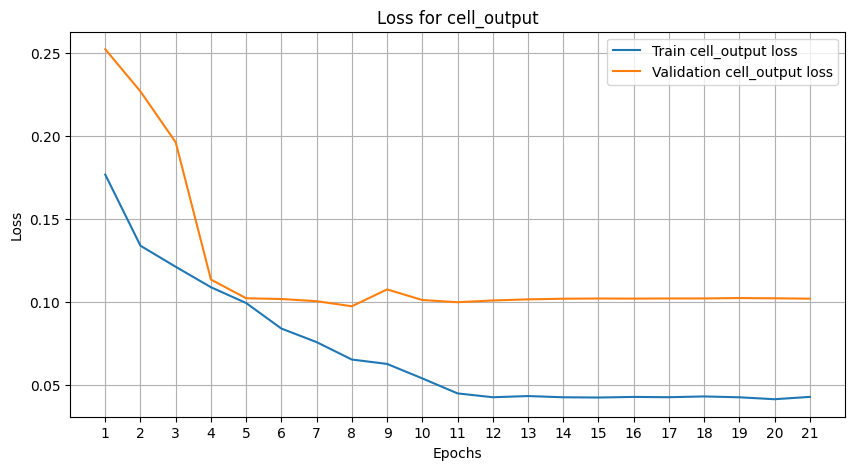

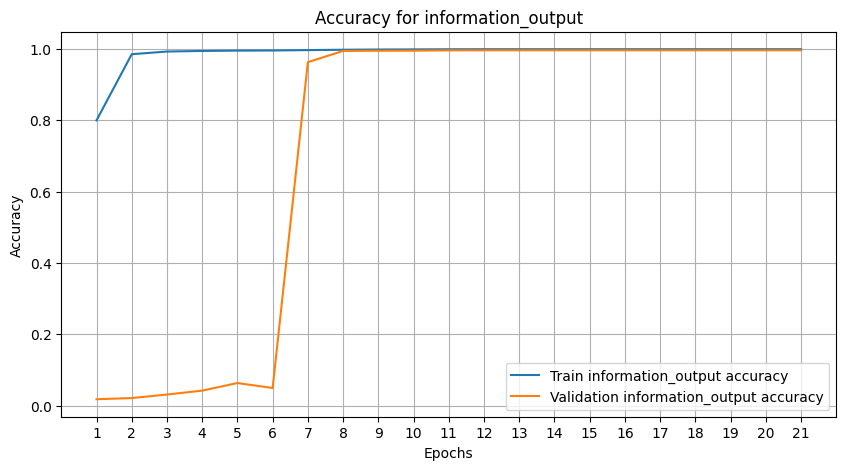

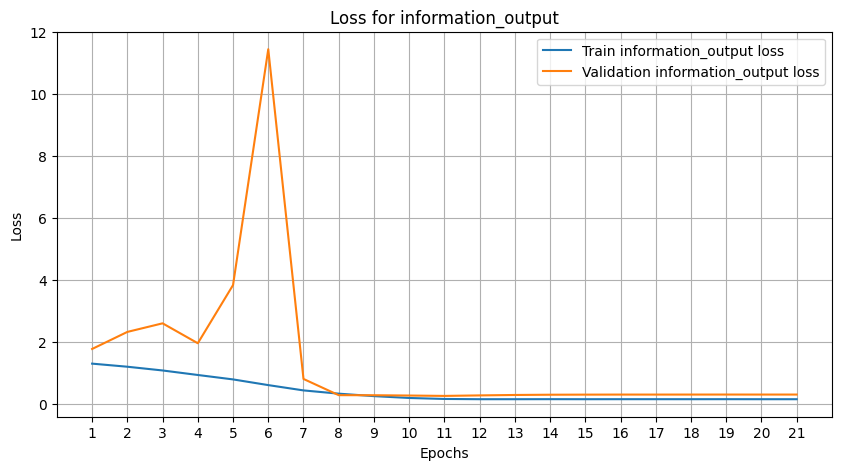

In [38]:
for annotation_type in ANNOTATION_TYPES:
    plot_history(history, "accuracy", f"{annotation_type}_output")
    plot_history(history, "loss", f"{annotation_type}_output")

In [39]:
test_metrics = model.evaluate(test_dataset, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - cell_output_accuracy: 0.9264 - cell_output_binary_iou: 0.8376 - cell_output_loss: 0.0626 - information_output_accuracy: 0.9976 - information_output_binary_iou: 0.7893 - information_output_loss: 0.1585 - loss: 0.2211


In [40]:
test_results = {
    "Output": [f"{annotation.capitalize()} Output" for annotation in ANNOTATION_TYPES],
    "Loss": test_metrics[1:len(ANNOTATION_TYPES) + 1],
    "Accuracy (%)": [metric * 100 for metric in test_metrics[len(ANNOTATION_TYPES) + 1:2 * len(ANNOTATION_TYPES) + 1]],
    "IoU (%)": [metric * 100 for metric in test_metrics[2 * len(ANNOTATION_TYPES) + 1:]]
}

test_results_df = pd.DataFrame(test_results).round(2)

In [41]:
print("\nTest Results Table:")
test_results_df


Test Results Table:


,Output,Loss,Accuracy (%),IoU (%)
0,Cell Output,0.06,92.64,99.76
1,Information Output,0.16,83.76,78.93


In [42]:
def post_process_mask(predicted_mask, threshold=0.5):
    mask = (predicted_mask > threshold).astype(np.uint8)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

In [43]:
def visualize_test_predictions(model, test_dataset, num_samples=5, thresholds=None):
    if thresholds is None:
        thresholds = {annotation_type: 0.5 for annotation_type in ANNOTATION_TYPES}

    for images, true_masks in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)
        pred_masks = {}

        for annotation_type in ANNOTATION_TYPES:
            pred_mask_raw = predictions[ANNOTATION_TYPES.index(annotation_type)]
            pred_mask = (pred_mask_raw > thresholds.get(annotation_type, 0.5)).astype(np.float32)

            if annotation_type == "information":
                pred_mask = np.array([post_process_mask(mask) for mask in pred_mask])

            pred_masks[annotation_type] = pred_mask

        for i in range(min(num_samples, len(images))):
            num_subplots = 1 + 2 * len(ANNOTATION_TYPES)
            plt.figure(figsize=(5 * num_subplots, 5))
            plt.subplot(1, num_subplots, 1)
            plt.imshow(images[i].numpy())
            plt.title("Original Image")
            plt.axis("off")

            for j, annotation_type in enumerate(ANNOTATION_TYPES):
                plt.subplot(1, num_subplots, 2 * j + 2)
                true_mask = true_masks[f"{annotation_type}_output"][i].numpy().squeeze()
                plt.imshow(true_mask, cmap="gray")
                plt.title(f"True {annotation_type.capitalize()} Mask")
                plt.axis("off")

                plt.subplot(1, num_subplots, 2 * j + 3)
                pred_mask = pred_masks[annotation_type][i].squeeze()
                plt.imshow(pred_mask, cmap="gray")

                true_mask_flat = true_masks[f"{annotation_type}_output"][i].numpy().squeeze().flatten()
                pred_mask_flat = pred_masks[annotation_type][i].squeeze().flatten()
                accuracy = np.mean(np.equal(true_mask_flat, pred_mask_flat))
                plt.title(f"Predicted {annotation_type.capitalize()} Mask\n(Accuracy={accuracy:.4f})")
                plt.axis("off")

            plt.tight_layout()
            plt.show()

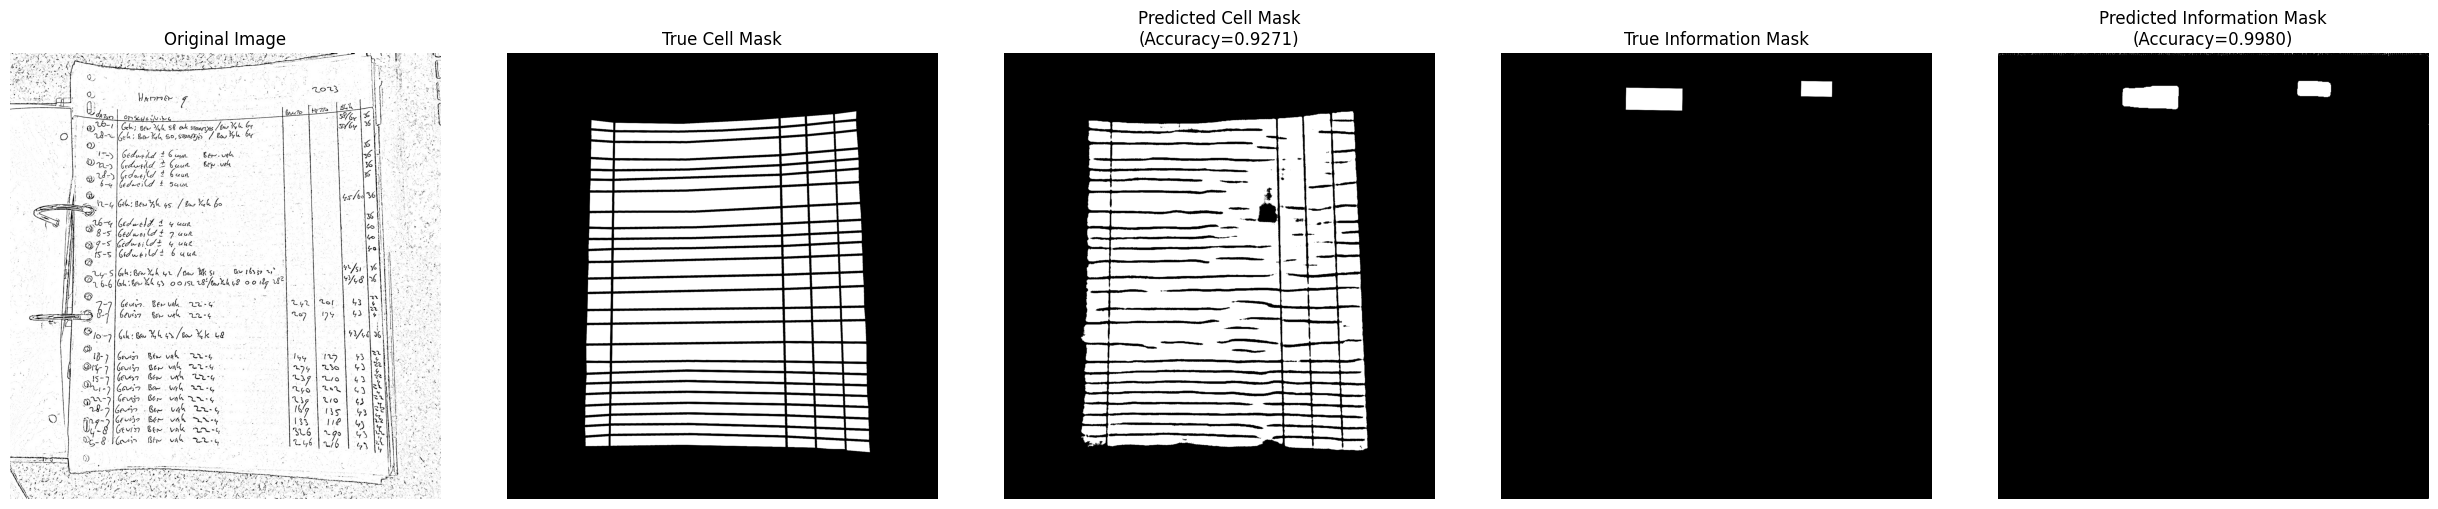

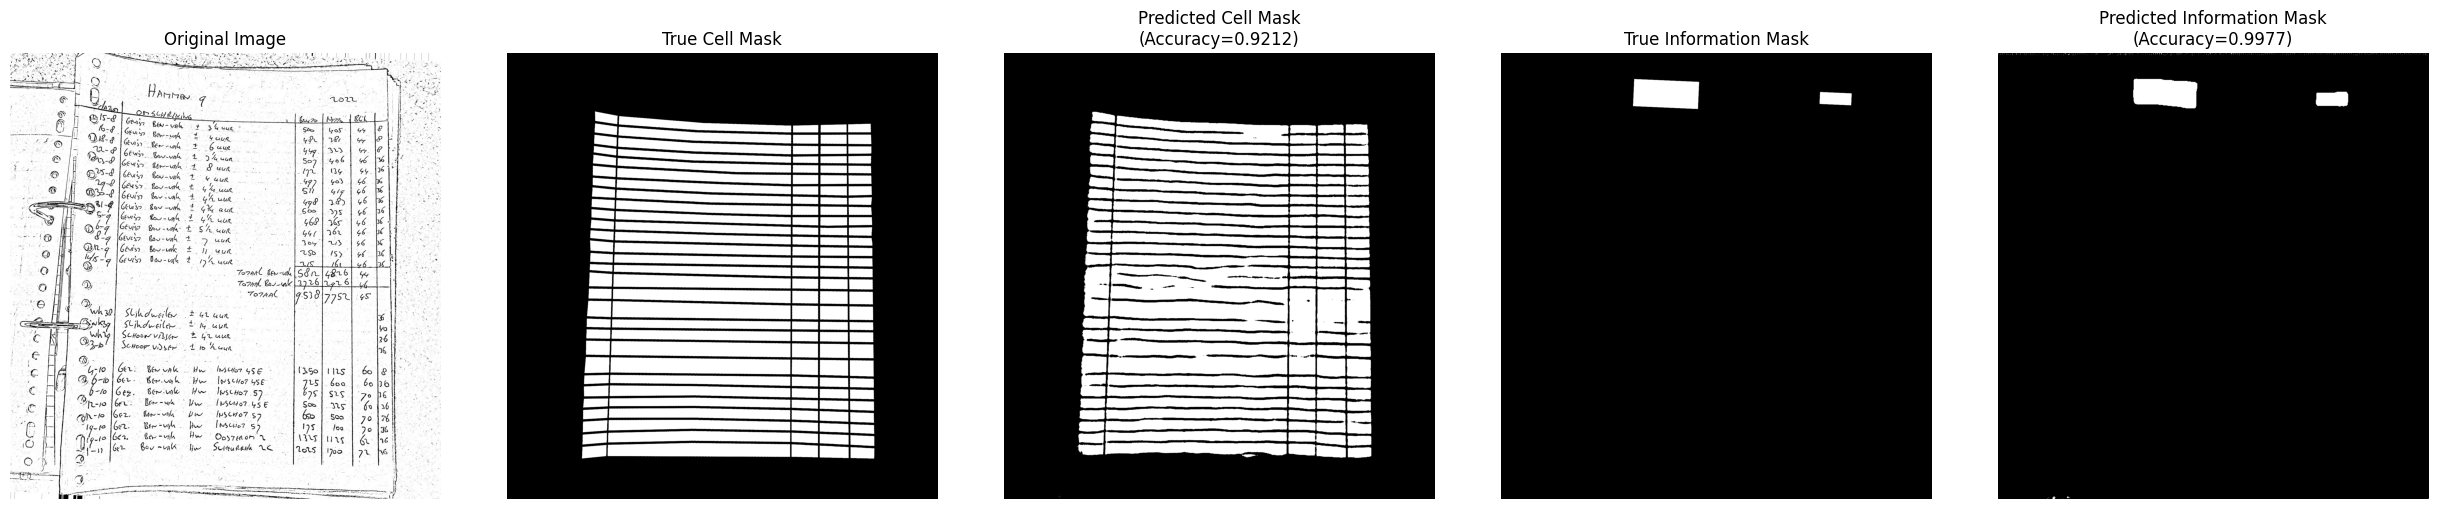

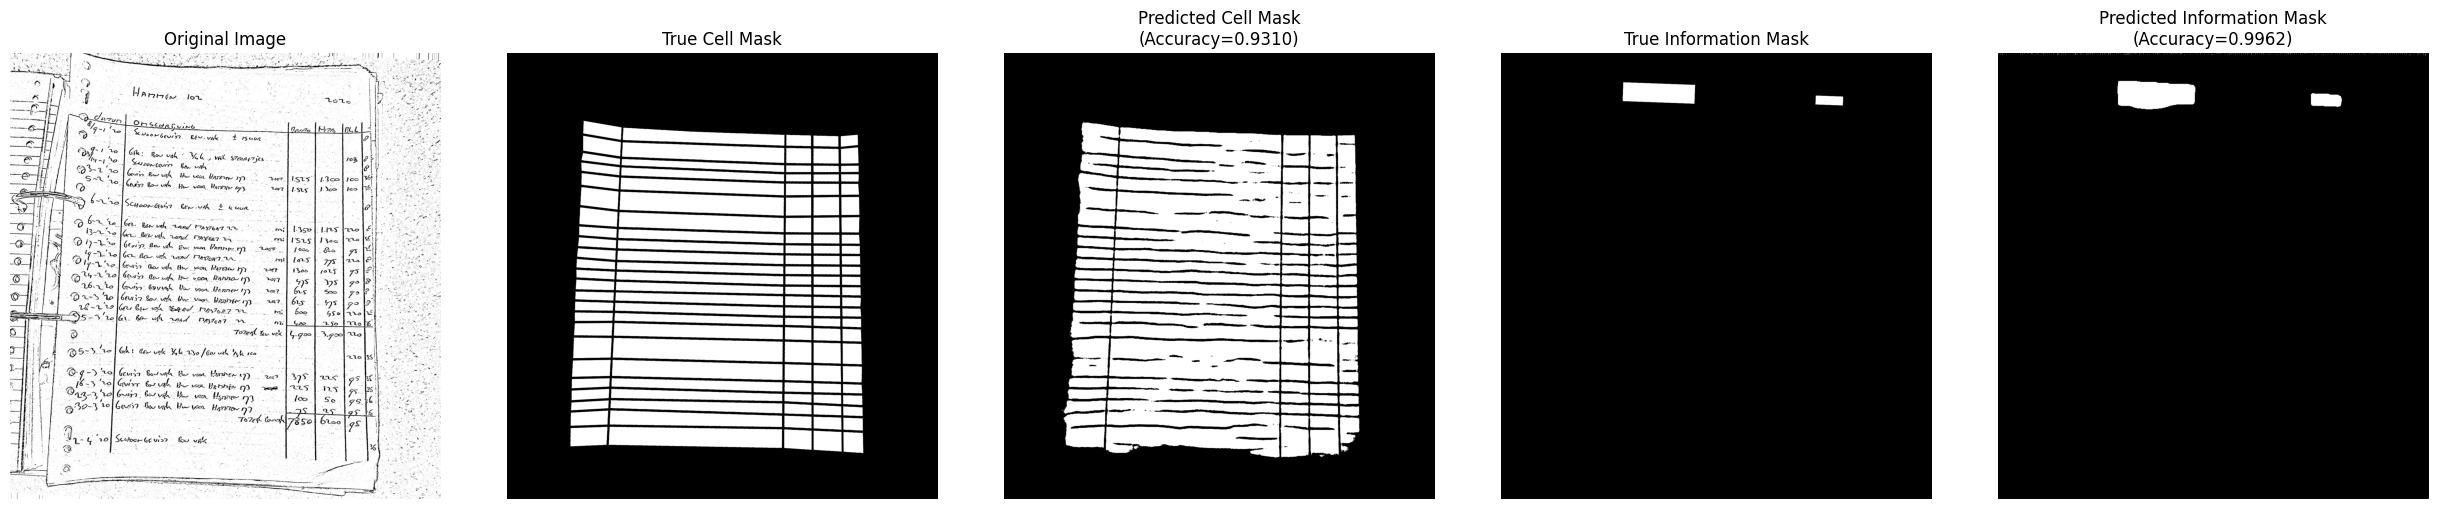

In [44]:
thresholds = {
    "row": 0.4,
    "column": 0.6,
    "cell": 0.5,
    "information": 0.4
}

# Call visualization function
visualize_test_predictions(model, test_dataset, thresholds=thresholds)

In [45]:
def load_image(image_input, input_shape):
    if isinstance(image_input, str):
        image = tf.io.read_file(image_input)
    else:
        uploaded = files.upload()
        if len(uploaded) == 0:
            raise ValueError("No file uploaded.")
        uploaded_file = list(uploaded.keys())[0]
        image = tf.io.read_file(uploaded_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image_resized = tf.image.resize(image, (input_shape[0], input_shape[1]))
    return image, tf.cast(image_resized, tf.float32) / 255.0

In [46]:
def get_information_bounding_boxes(pred_mask, padding=5, input_shape=None, original_shape=None, min_width=10, min_height=10):
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for (x, y, w, h) in [cv2.boundingRect(contour) for contour in contours]:
        if w >= min_width and h >= min_height:
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(w + 2 * padding, input_shape[1] - x)
            h = min(h + 2 * padding, input_shape[0] - y)
            if original_shape:
                x = int(x * original_shape[1] / input_shape[1])
                y = int(y * original_shape[0] / input_shape[0])
                w = int(w * original_shape[1] / input_shape[1])
                h = int(h * original_shape[0] / input_shape[0])
            bounding_boxes.append((x, y, w, h))
    return bounding_boxes

In [47]:
def get_cell_polygons(cell_mask, min_area=50, epsilon_factor=0.005, padding_top_bottom=10):
    contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            epsilon = epsilon_factor * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            approx = approx.squeeze()

            # Add padding to top and bottom
            if approx.ndim == 2:  # Ensure it's not empty
                approx[:, 1] = np.clip(approx[:, 1] - padding_top_bottom, 0, cell_mask.shape[0])
                approx[:, 1] = np.clip(approx[:, 1] + padding_top_bottom, 0, cell_mask.shape[0])

            polygons.append(approx)
    return polygons

In [48]:
def enhance_cell_mask(cell_mask, min_line_length=100, max_line_gap=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_mask = cv2.morphologyEx(cell_mask, cv2.MORPH_CLOSE, kernel)

    edges = cv2.Canny(closed_mask, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=min_line_length, maxLineGap=max_line_gap)

    enhanced_mask = closed_mask.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(enhanced_mask, (x1, y1), (x2, y2), 255, thickness=2)

    return enhanced_mask

In [49]:
def visualize_uploaded_image_with_polygons(model, input_shape, thresholds, image_input=None):
    image, image_resized_norm = load_image(image_input, input_shape)
    image_resized_norm = tf.expand_dims(image_resized_norm, axis=0)
    predictions = model.predict(image_resized_norm)

    processed_masks = {annotation_type: (predictions[ANNOTATION_TYPES.index(annotation_type)] > thresholds[annotation_type]).astype(np.uint8).squeeze() for annotation_type in thresholds}

    information_mask = processed_masks["information"]
    information_boxes = get_information_bounding_boxes(information_mask, padding=5, input_shape=input_shape, original_shape=image.shape)

    cell_mask = processed_masks["cell"]
    enhanced_cell_mask = enhance_cell_mask(cell_mask)
    cell_polygons = get_cell_polygons(enhanced_cell_mask, min_area=50, epsilon_factor=0.005, padding_top_bottom=10)

    original_image_with_info_boxes = image.numpy()
    original_image_with_cell_polygons = image.numpy()

    for (x, y, w, h) in information_boxes:
        cv2.rectangle(original_image_with_info_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

    for polygon in cell_polygons:
        if len(polygon.shape) == 2:  # Ensure the contour has points
            cv2.drawContours(original_image_with_cell_polygons, [polygon], -1, (0, 255, 0), 2)

    plt.figure(figsize=(25, 10))
    plt.subplot(1, 5, 1)
    plt.imshow(tf.image.convert_image_dtype(image, tf.uint8).numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(original_image_with_cell_polygons, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Cell Polygons")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(original_image_with_info_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Information Bounding Boxes")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(cell_mask, cmap="gray")
    plt.title("Cell Mask")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(information_mask, cmap="gray")
    plt.title("Information Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


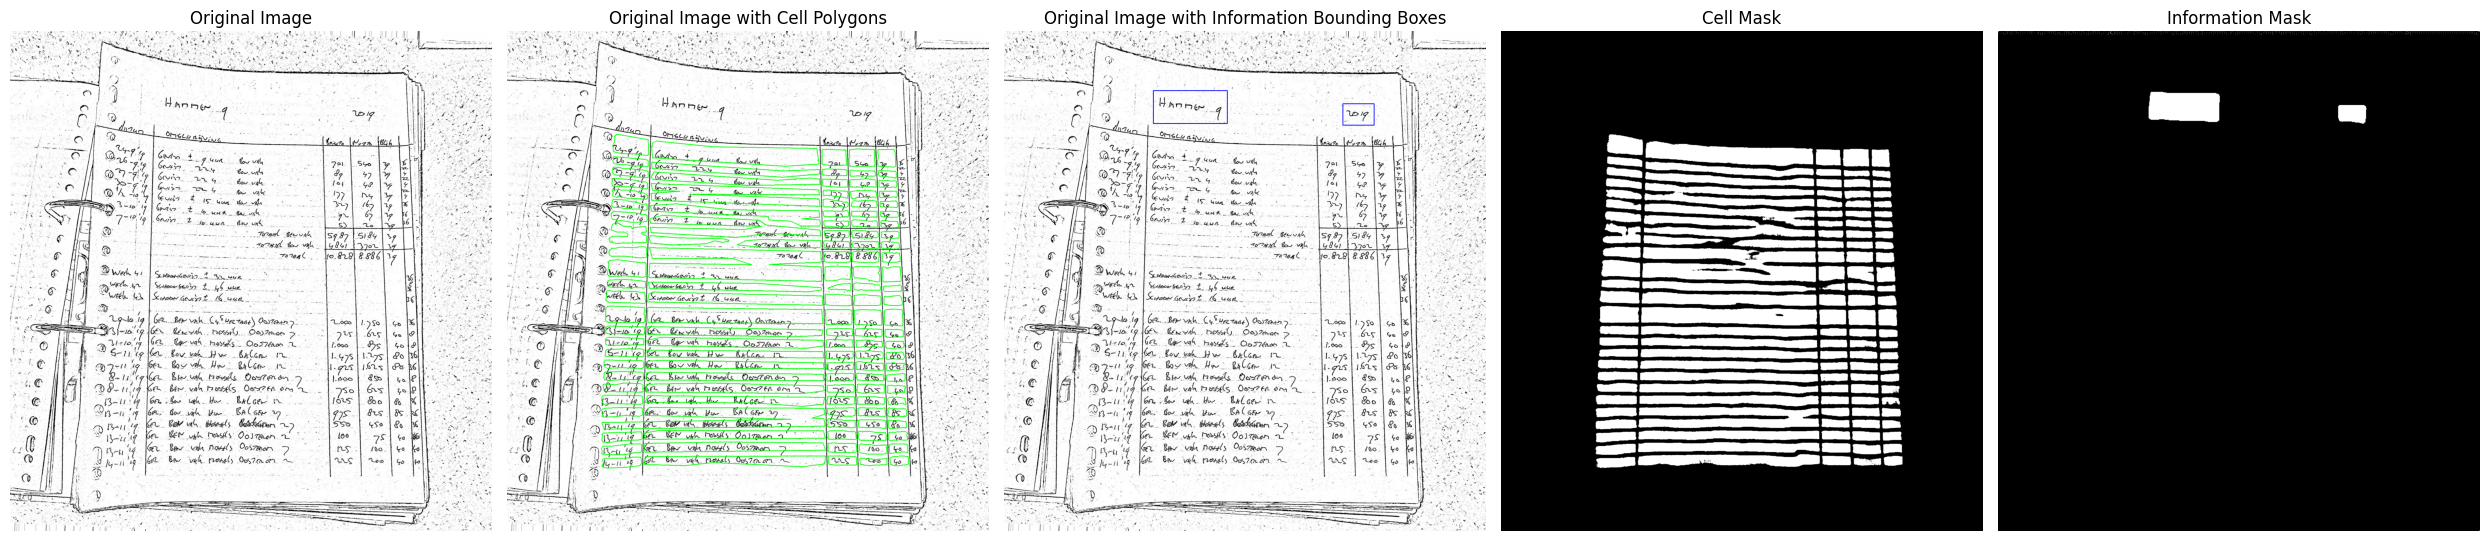

In [54]:
thresholds = {
    "cell": 0.95,
    "information": 0.4
}

image_input = IMAGE_FOLDER + "/DSC00937.JPG"

visualize_uploaded_image_with_polygons(model, input_shape=TARGET_SIZE, thresholds=thresholds, image_input=image_input)

In [55]:
model.save('tablenet_model.h5', include_optimizer=True)